<a href="https://colab.research.google.com/github/yumakemore/MedicationEmbedding/blob/master/MedicationEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedicationEmbedding
Note: You must upload concepts in a csv and events in a csv under the folder icon on the left bar on Colab to run this notebook. 




In [0]:
import pandas as pd
import sys




Read Medication Events (event_csv.csv) into a Pandas DataFrame (event_df);
Read Medication Concepts (concept_csv.csv) into a Pandas DataFrame (concept_df).

In [0]:
import datetime

# Path to the data file
location = r'./event_csv.csv'
#location = 'https://drive.google.com/open?id=1vbZ8LTh7luNR7dmzZk30iKLeWSBkNAk3'

# Parse the data file
event_df = pd.read_csv(location, sep=',', dtype={'encounter':'Int64'})
event_df['start_date']=pd.to_datetime(event_df['start_date'])
event_df['last_modified']=pd.to_datetime(event_df['last_modified'])
event_df['date_recorded']=pd.to_datetime(event_df['date_recorded'])

# Path to the data file
location = r'./concept_csv.csv'
#location = 'https://drive.google.com/open?id=1h9Ok1O740qbz70qLpbmUVX-0Ga5BVt0S'

# Parse the data file
concept_df = pd.read_csv(location, sep=',')
concept_df['start_date']=pd.to_datetime(concept_df['start_date'])
concept_df['end_date']=pd.to_datetime(concept_df['end_date'])

#Check out the data
print("---event_df Schema---\n")
print(event_df.dtypes,"\n")
print("---event_df First 5 Rows---\n")
print(event_df.head(),"\n")
#print(event_df.tail())
print("---concept_df Schema---\n")
print(concept_df.dtypes,"\n")
print("---concept_df First 5 Rows---\n")
print(concept_df.head(),"\n")
#print(concept_df.tail())

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', None)

# Word/Name Embedding to capture the concepts co-occurrance as vector similarity

In [0]:
import re

concept_df_sort_by_user=concept_df.sort_values(['user','start_date'])
concept_df_sort_by_user=concept_df_sort_by_user.reset_index(drop=True)
#print (concept_df_sort_by_user.head(100))
for index, row in concept_df_sort_by_user.iterrows():
  try:
    if concept_df_sort_by_user.at[index,'user'] != concept_df_sort_by_user.at[index-1,'user']:
      concept_df_sort_by_user.at[index-1,'name_clean']= str(concept_df_sort_by_user.at[index-1,'name_clean'])+"\n"
  except:
      continue

concept_text=str(concept_df_sort_by_user['name_clean'].str.cat(sep=' '))
concept_text=re.sub('\n\s+', '\n', concept_text)

print(concept_text)

f = open("./concept_name_clean.txt", "w")
f.write(concept_text)
f.close()

# Neural Network Preparation

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

     |████████████████████████████████| 517.2MB 30kB/s 
     |████████████████████████████████| 2.9MB 48.4MB/s 
     |████████████████████████████████| 460kB 45.7MB/s 


In [0]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
#--- Load Data from concept_name_clean.txt
def labeler(example, index):
  return example, tf.cast(index, tf.int64)
labeled_data_sets = []
lines_dataset = tf.data.TextLineDataset('./concept_name_clean.txt')
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))
labeled_data_sets.append(labeled_dataset)


In [0]:
BUFFER_SIZE = 500
BATCH_SIZE = 4
TAKE_SIZE = 10

all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
  
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

for ex in all_labeled_data.take(5):
  print(ex)


In [10]:
tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

288

In [0]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)
example_text = next(iter(all_labeled_data))[0].numpy()
print(example_text)
encoded_example = encoder.encode(example_text)
print(encoded_example)

In [0]:
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label


In [0]:
def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))

  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label


all_encoded_data = all_labeled_data.map(encode_map_fn)

In [14]:
train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE)

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

try:
  print (next(iter(train_data)))
except:
  print("End of dataset")  # ==> "End of dataset"
print (next(iter(test_data)))

(<tf.Tensor: shape=(4, 58), dtype=int64, numpy=
array([[ 65, 107, 287, 121, 126,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  5, 275, 249, 266, 282, 178,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [257,  75,  25, 259, 192, 237,  67,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0

In [15]:
sample_text, sample_labels = next(iter(test_data))

print (sample_text[0], "\n", sample_labels[0], "\n\n")
print (sample_text[1], "\n", sample_labels[1])

tf.Tensor(
[ 19  61 147 173 221 285   7 224 175  41 278 136 154  14  69  98 172 201
 110  46 176 215 234 156   0   0   0], shape=(27,), dtype=int64) 
 tf.Tensor(0, shape=(), dtype=int64) 


tf.Tensor(
[160  57   1  82  59  30 102  74 284  37  42 173 118 144 102 190  51 158
 103 195 148 268  20 250 243 269 210], shape=(27,), dtype=int64) 
 tf.Tensor(0, shape=(), dtype=int64)


In [0]:
vocab_size += 1

# LSTM Model

In [17]:
embedding_dim=16
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
# One or more dense layers.
# Edit the list in the `for` line to experiment with layer sizes.
for units in [embedding_dim, embedding_dim]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))

# Output layer. The first argument is the number of labels.
model.add(tf.keras.layers.Dense(3))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          4624      
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 9,699
Trainable params: 9,699
Non-trainable params: 0
_________________________________________________________________


In [18]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    #train_batches,
    train_data,
    epochs=100,
    #validation_data=test_batches, validation_steps=20)
    validation_data=test_data)

Epoch 1/100
5/5 [==============================] - 1s 168ms/step - loss: 1.0878 - accuracy: 0.8333 - val_loss: 1.0707 - val_accuracy: 1.0000
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 1.0508 - accuracy: 1.0000 - val_loss: 1.0198 - val_accuracy: 1.0000
Epoch 3/100
5/5 [==============================] - 0s 25ms/step - loss: 0.9925 - accuracy: 1.0000 - val_loss: 0.9487 - val_accuracy: 1.0000
Epoch 4/100
5/5 [==============================] - 0s 21ms/step - loss: 0.9029 - accuracy: 1.0000 - val_loss: 0.8540 - val_accuracy: 1.0000
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 0.8194 - accuracy: 1.0000 - val_loss: 0.7321 - val_accuracy: 1.0000
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 0.6536 - accuracy: 1.0000 - val_loss: 0.5787 - val_accuracy: 1.0000
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 0.4829 - accuracy: 1.0000 - val_loss: 0.3887 - val_accuracy: 1.0000
Epoch 8/100
5/5 [==

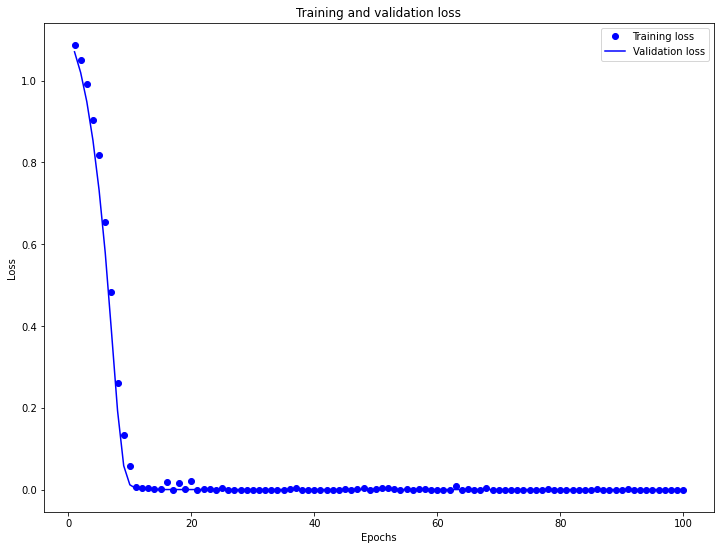

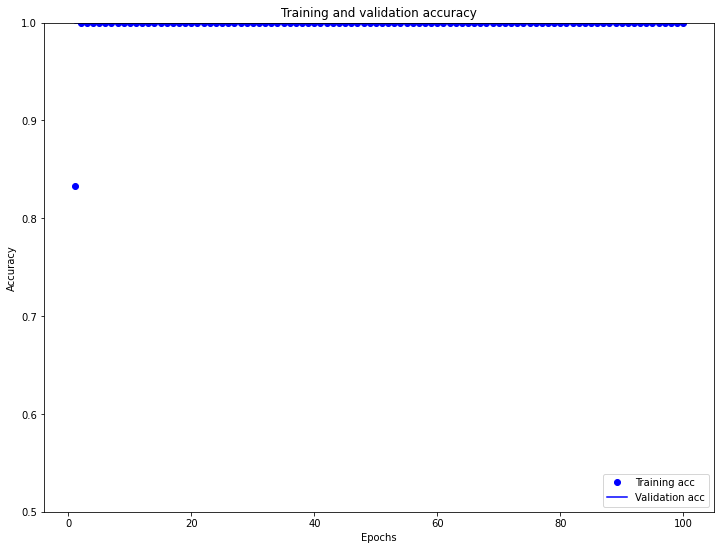

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [20]:
eval_loss, eval_acc = model.evaluate(test_data)

print('\nEval loss: {:.12f}, Eval accuracy: {:.12f}'.format(eval_loss, eval_acc))


3/3 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000

Eval loss: 0.000000000000, Eval accuracy: 1.000000000000


In [21]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(289, 16)


In [0]:
print (vocabulary_set)

In [0]:
import io

#encoder = info.features['text'].encoder

out_v = io.open('vecs_LSTM.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_LSTM.tsv', 'w', encoding='utf-8')

#for num, word in enumerate(encoder.subwords):
for num, word in enumerate(vocabulary_set):
  print (num, "\n", word)
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs_LSTM.tsv')
  files.download('meta_LSTM.tsv')

Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.
Open the Embedding Projector (http://projector.tensorflow.org).
Click on "Load data". Upload the two files we created above: vecs_LSTM.tsv and meta_LSTM.tsv. The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".


# Alternative: Pooling instead of LSTM (lower performance)


In [0]:
embedding_layer = layers.Embedding(100, 5)

In [26]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [0]:
train_batches = train_data.shuffle(100).padded_batch(10)
test_batches = test_data.shuffle(100).padded_batch(10)

In [28]:
train_batch, train_labels = next(iter(train_batches))
print (train_batch, "\n\n",train_labels,"\n")
train_batch.numpy()

tf.Tensor(
[[[216 128  44 ...   0   0   0]
  [170  95  44 ...   0   0   0]
  [251 128  44 ...   0   0   0]
  [168 197 153 ... 159 116  17]]

 [[169 205  47 ...   0   0   0]
  [ 65 107 287 ...   0   0   0]
  [113  29 139 ...   0   0   0]
  [251 204   1 ...   0   0   0]]

 [[164 183 208 ...   0   0   0]
  [  5 275 249 ...   0   0   0]
  [ 62 169  34 ...   0   0   0]
  [138   7 224 ...   0   0   0]]

 [[257  75  25 ...   0   0   0]
  [124 162  68 ...   0   0   0]
  [ 84  15  26 ...   0   0   0]
  [ 63  83 218 ...   0   0   0]]

 [[ 87  96 107 ...   0   0   0]
  [233 119 213 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]], shape=(5, 4, 58), dtype=int64) 

 tf.Tensor(
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]], shape=(5, 4), dtype=int64) 



array([[[216, 128,  44, ...,   0,   0,   0],
        [170,  95,  44, ...,   0,   0,   0],
        [251, 128,  44, ...,   0,   0,   0],
        [168, 197, 153, ..., 159, 116,  17]],

       [[169, 205,  47, ...,   0,   0,   0],
        [ 65, 107, 287, ...,   0,   0,   0],
        [113,  29, 139, ...,   0,   0,   0],
        [251, 204,   1, ...,   0,   0,   0]],

       [[164, 183, 208, ...,   0,   0,   0],
        [  5, 275, 249, ...,   0,   0,   0],
        [ 62, 169,  34, ...,   0,   0,   0],
        [138,   7, 224, ...,   0,   0,   0]],

       [[257,  75,  25, ...,   0,   0,   0],
        [124, 162,  68, ...,   0,   0,   0],
        [ 84,  15,  26, ...,   0,   0,   0],
        [ 63,  83, 218, ...,   0,   0,   0]],

       [[ 87,  96, 107, ...,   0,   0,   0],
        [233, 119, 213, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]])

In [29]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          4640      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    #train_batches,
    train_data,
    epochs=100,
    #validation_data=test_batches, validation_steps=20)
    validation_data=test_data)

Epoch 1/100
5/5 [==============================] - 0s 26ms/step - loss: 0.6782 - accuracy: 1.0000 - val_loss: 0.6742 - val_accuracy: 1.0000
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.6633 - accuracy: 1.0000 - val_loss: 0.6621 - val_accuracy: 1.0000
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.6549 - accuracy: 1.0000 - val_loss: 0.6492 - val_accuracy: 1.0000
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.6354 - accuracy: 1.0000 - val_loss: 0.6352 - val_accuracy: 1.0000
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.6160 - accuracy: 1.0000 - val_loss: 0.6203 - val_accuracy: 1.0000
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.5980 - accuracy: 1.0000 - val_loss: 0.6047 - val_accuracy: 1.0000
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.5818 - accuracy: 1.0000 - val_loss: 0.5888 - val_accuracy: 1.0000
Epoch 8/100
5/5 [=========

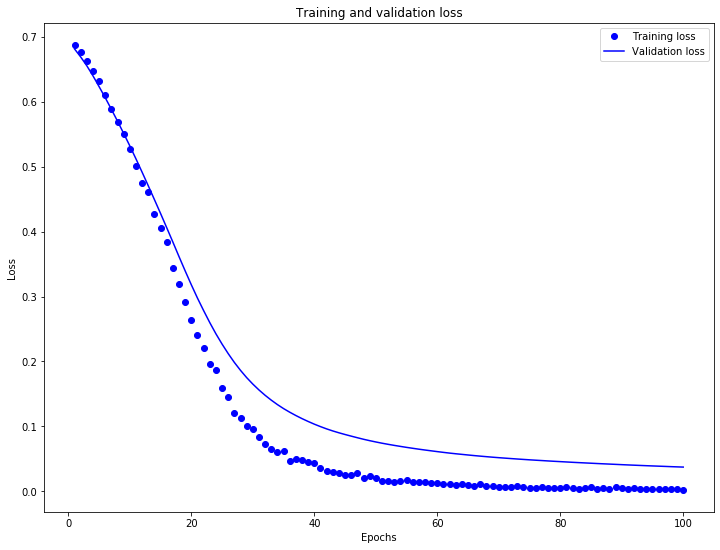

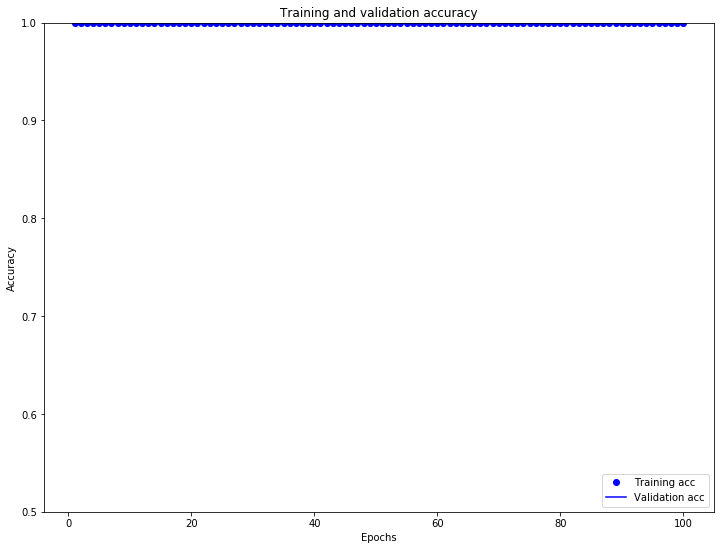

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [31]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(290, 16)


In [0]:
print (vocabulary_set)

In [0]:
import io

#encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

#for num, word in enumerate(encoder.subwords):
for num, word in enumerate(vocabulary_set):
  print (num, "\n", word)
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

# Visualize the embeddings
To visualize our embeddings we will upload them to the embedding projector.

Open the Embedding Projector (http://projector.tensorflow.org).

Click on "Load data".
Upload the two files we created above: vecs.tsv and meta.tsv.
The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".

![alt text](https://)